In [2]:
import sys
import numpy as np
import pandas as pd 
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")

In [3]:
tfk = tf.keras
tfkl=tf.keras.layers
tfpl= tfp.layers         # layers for tensor flow probability 
tfd = tfp.distributions # distribution layer 

In [10]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# make sure GPU is running 
tf.test.gpu_device_name()
# set max limit to 7.5 G /8 total available 
set_gpu_limit(7.5)

## Import training and dev data and convert to numpy array for NN 

In [16]:
train = pd.read_csv("../processedData/TrainingData_normal.csv")
dev = pd.read_csv("../processedData/DevData_normal.csv")

### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 1000 epochs 

In [17]:
buffer_size = 10000
batch_size = 256
epochs = 500
input_size = train.shape[1]
encoded_size = 5

In [19]:
train_data, dev_data = make_tensor_dataset([train,dev],buffer_size,batch_size)

### set up checkpoint and other settings 

In [20]:
checkpoint = tfk.callbacks.ModelCheckpoint("../savedModels/VariationalEncoderModel_2.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=20, verbose=1, restore_best_weights=True)

### For variational autoencoder we need to maximize ELBO (evidence lower bound objective):

$$ELBO(x)= \int dzq(z|x)logp(x|z) + \int dzq(z|x)log\frac{q(z|x)}{p(z)} $$

* p(z): the prior on the latent representation z (last layer of encoder) 
* q(z|x_input): the encoder (how likely is z given x_input)
* p(x_hat|z): the decoder (how likely is x_hat given z) 
* $\int dzq(z|x)logp(x|z)$: reconstructin term. (how likely for us to get output_x given input_x and encode to z then decode to x_output) 
* $\int dzq(z|x)log\frac{q(z|x)}{p(z)} $: KL divergence. How similar are the encoder distribution and the prior distribution. 

### Prior distribution for z: 

* Since this is latent representation (noise has been removed), it is okay to assume it is isotropic gaussian 

In [21]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 
  * 3 dimensional multivariable non zero covariance normal distribution

In [11]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape = input_size),  # 30 input features 
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),activation=None),
    tfpl.MultivariateNormalTriL(encoded_size,activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name="encoder")
encoder.summary()    

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0
_________________________________________________________________


## decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers
   * independent normal distributions as output 

In [12]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_size),activation=None),
    tfpl.IndependentNormal(input_size)
    ], name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 60)                1260      
_________________________________________________________________
independent_normal (Independ ((None, 30), (None, 30))  0         
Total params: 1,540
Trainable params: 1,540
Non-trainable params: 0
_________________________________________________________________


### Add encoders together 


In [13]:
VAE = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]),name="VAE")

In [14]:
VAE.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1540      
Total params: 2,590
Trainable params: 2,590
Non-trainable params: 0
_____________________________________________________________

### define reconstruction loss

In [15]:
negloglik = lambda x_input, x_output: -x_output.log_prob(x_input)

### compile the model and train model

In [16]:
VAE.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [17]:
history = VAE.fit(train,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev,
                          callbacks=[checkpoint,earlystop])

Epoch 1/500
706/711 [============================>.] - ETA: 0s - loss: 714.3268
Epoch 00001: val_loss improved from inf to 127.02262, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 710.1678 - val_loss: 127.0226
Epoch 2/500
702/711 [============================>.] - ETA: 0s - loss: 618.9617
Epoch 00002: val_loss improved from 127.02262 to 101.20383, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 612.4127 - val_loss: 101.2038
Epoch 3/500
700/711 [============================>.] - ETA: 0s - loss: 352046.9375
Epoch 00003: val_loss improved from 101.20383 to 86.85255, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 346600.1562 - val_loss: 86.8525
Epoch 4/500
710/711 [============================>.] - ETA: 0s - loss: 143.5374
Epoch 00004: val_loss improved from 86.8525

Epoch 30/500
703/711 [============================>.] - ETA: 0s - loss: 42.6498
Epoch 00030: val_loss improved from 43.02106 to 42.30232, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 42.6443 - val_loss: 42.3023
Epoch 31/500
696/711 [============================>.] - ETA: 0s - loss: 41.9472
Epoch 00031: val_loss improved from 42.30232 to 41.64722, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 41.9415 - val_loss: 41.6472
Epoch 32/500
705/711 [============================>.] - ETA: 0s - loss: 41.3181
Epoch 00032: val_loss improved from 41.64722 to 41.05382, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 41.3124 - val_loss: 41.0538
Epoch 33/500
701/711 [============================>.] - ETA: 0s - loss: 40.8512
Epoch 00033: val_loss improved from 41.05382 to 40.67

Epoch 59/500
709/711 [============================>.] - ETA: 0s - loss: 33.5873
Epoch 00059: val_loss improved from 33.68774 to 33.61109, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 33.5866 - val_loss: 33.6111
Epoch 60/500
710/711 [============================>.] - ETA: 0s - loss: 33.5035
Epoch 00060: val_loss did not improve from 33.61109
711/711 [==============================] - 3s 4ms/step - loss: 33.5023 - val_loss: 33.7342
Epoch 61/500
708/711 [============================>.] - ETA: 0s - loss: 33.4175
Epoch 00061: val_loss improved from 33.61109 to 33.45820, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 33.4166 - val_loss: 33.4582
Epoch 62/500
706/711 [============================>.] - ETA: 0s - loss: 33.3496
Epoch 00062: val_loss improved from 33.45820 to 33.41706, saving model to ../savedModels/VariationalEncoderModel_2.h5
7

Epoch 89/500
698/711 [============================>.] - ETA: 0s - loss: 32.4080
Epoch 00089: val_loss did not improve from 32.48016
711/711 [==============================] - 3s 4ms/step - loss: 32.4095 - val_loss: 32.5155
Epoch 90/500
711/711 [==============================] - ETA: 0s - loss: 32.3942
Epoch 00090: val_loss did not improve from 32.48016
711/711 [==============================] - 3s 4ms/step - loss: 32.3942 - val_loss: 32.5202
Epoch 91/500
703/711 [============================>.] - ETA: 0s - loss: 32.3912
Epoch 00091: val_loss improved from 32.48016 to 32.46402, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.3888 - val_loss: 32.4640
Epoch 92/500
703/711 [============================>.] - ETA: 0s - loss: 32.3788
Epoch 00092: val_loss improved from 32.46402 to 32.44158, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.3

Epoch 121/500
703/711 [============================>.] - ETA: 0s - loss: 32.0114
Epoch 00121: val_loss improved from 32.07141 to 32.06533, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.0144 - val_loss: 32.0653
Epoch 122/500
708/711 [============================>.] - ETA: 0s - loss: 32.0009
Epoch 00122: val_loss improved from 32.06533 to 32.04026, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.0030 - val_loss: 32.0403
Epoch 123/500
701/711 [============================>.] - ETA: 0s - loss: 32.0012
Epoch 00123: val_loss improved from 32.04026 to 32.03185, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 31.9965 - val_loss: 32.0319
Epoch 124/500
699/711 [============================>.] - ETA: 0s - loss: 32.0085
Epoch 00124: val_loss did not improve from 32.031

Epoch 155/500
703/711 [============================>.] - ETA: 0s - loss: 33.5255
Epoch 00155: val_loss did not improve from 31.90421
711/711 [==============================] - 3s 4ms/step - loss: 33.5200 - val_loss: 33.4154
Epoch 156/500
704/711 [============================>.] - ETA: 0s - loss: 33.1434
Epoch 00156: val_loss did not improve from 31.90421
711/711 [==============================] - 3s 4ms/step - loss: 33.1366 - val_loss: 33.0443
Epoch 157/500
708/711 [============================>.] - ETA: 0s - loss: 32.8024
Epoch 00157: val_loss did not improve from 31.90421
711/711 [==============================] - 3s 4ms/step - loss: 32.8000 - val_loss: 32.7997
Epoch 158/500
703/711 [============================>.] - ETA: 0s - loss: 32.5179
Epoch 00158: val_loss did not improve from 31.90421
711/711 [==============================] - 3s 4ms/step - loss: 32.5122 - val_loss: 32.4923
Epoch 159/500
710/711 [============================>.] - ETA: 0s - loss: 32.3007
Epoch 00159: val_loss d

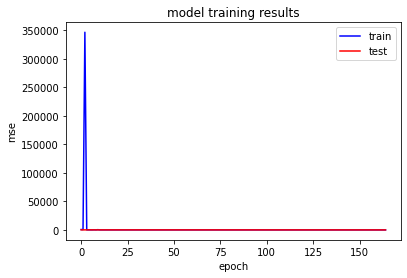

In [19]:
plot_loss(history)

In [9]:
encoder, decoder, VAE = create_model(input_size, encoded_size)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [11]:
VAE.load_weights("../savedModels/VariationalEncoderModel.h5")

### create monte carlo to generate output log prob score for anomaly prediction

In [12]:
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

In [13]:
test_tf_data, label = test.drop("Class",axis=1).values, test["Class"]

In [14]:
x_log_prob = reconstruction_log_prob(test_tf_data,encoder,decoder)

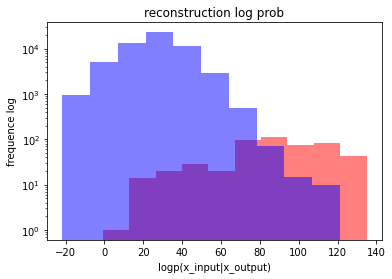

In [15]:
neg_log_prob(-x_log_prob,label)

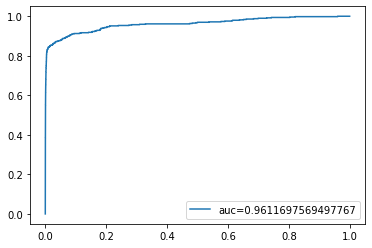

In [16]:
plot_roc(label,-x_log_prob)

### Choose a threshold that gives a good overall class1 recall 

In [23]:
model_results(label,-x_log_prob,75)

[[56717   141]
 [  131   361]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.72      0.73      0.73       492

    accuracy                           1.00     57350
   macro avg       0.86      0.87      0.86     57350
weighted avg       1.00      1.00      1.00     57350

